## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [28]:
!pip install nlp

In [29]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [30]:
import pandas as pd

splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])

In [32]:
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.1, random_state=42)

validation_df, test_df = train_test_split(temp_df, test_size=0.4, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 14400
Validation set size: 960
Test set size: 640


In [33]:
def get_tweet(data):
  tweets = data['text'].tolist()  # Access the 'text' column directly and convert to list
  labels = data['label'].tolist()  # Access the 'label' column directly and convert to list
  return tweets, labels

In [37]:
tweets,labels=get_tweet(train_df)
tweets[10],labels[10]

('i remember feeling acutely distressed for a few days', 4)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [39]:
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

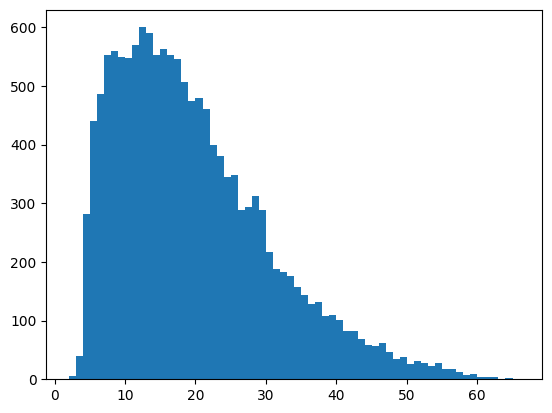

In [40]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [41]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [42]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,maxlen=maxlen,padding='post',truncating='post')
  return padded

In [43]:
padded_train=get_sequences(tokenizer,tweets)

In [45]:
padded_train[5]

array([   2,  122,   13,   33,   16,  232,    9,  634,   33,   16, 4899,
         12,    6, 2868,   35,   33,    2,    3, 4900,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [46]:
classes=set(labels)

In [47]:
classes

{0, 1, 2, 3, 4, 5}

In [48]:
index_to_classes={0:'sadness',1:'joy',2:'love',3:'anger',4:'fear',5:'surprise'}

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [49]:
from logging import logProcesses
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [50]:
val_tweets,val_labels=get_tweet(validation_df)
val_seq=get_sequences(tokenizer,val_tweets)
val_tweets[2],val_labels[2]

('there was a cat on the street it had been run over and its head was open we passed beside it',
 3)

In [51]:
train_dataset = tf.data.Dataset.from_tensor_slices((padded_train, labels))
val_seq_dataset = tf.data.Dataset.from_tensor_slices(val_seq)
val_labels_dataset = tf.data.Dataset.from_tensor_slices(val_labels)
val_dataset = tf.data.Dataset.zip((val_seq_dataset, val_labels_dataset))


h = model.fit(
    train_dataset.batch(32),
    validation_data=val_dataset.batch(32),
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)



Epoch 1/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3598 - loss: 1.5548 - val_accuracy: 0.6677 - val_loss: 0.8932
Epoch 2/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7406 - loss: 0.7130 - val_accuracy: 0.8146 - val_loss: 0.5675
Epoch 3/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8613 - loss: 0.4026 - val_accuracy: 0.8125 - val_loss: 0.6059
Epoch 4/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9069 - loss: 0.2677 - val_accuracy: 0.8344 - val_loss: 0.5244
Epoch 5/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9355 - loss: 0.1967 - val_accuracy: 0.8198 - val_loss: 0.6170


## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

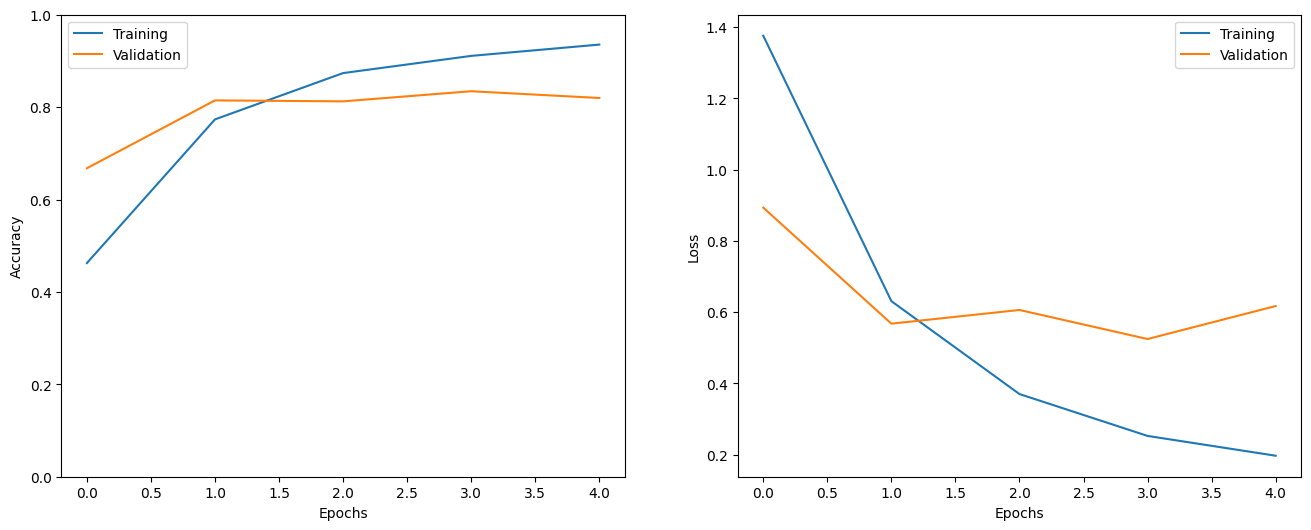

In [52]:
show_history(h)

Sequence: [  2   3  14   2  32 132  28 463   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]

Shape: (50,)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
Predicted Emotion: anger
Actual Emotion: anger
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


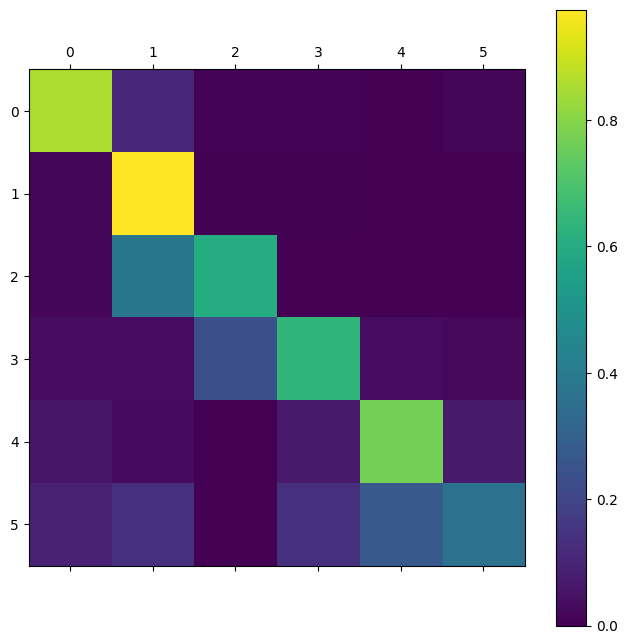

In [53]:
test_tweets, test_labels = get_tweet(test_df)
test_sequences = get_sequences(tokenizer, test_tweets)

# A look at individual predictions on the test set
i = random.randint(0, len(test_labels) - 1)
print('Sequence:', test_sequences[i])
print()
print('Shape:', test_sequences[i].shape)
print()
pred = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
pred_class = index_to_classes[np.argmax(pred).astype('uint8')]
print('Predicted Emotion:', pred_class)
print('Actual Emotion:', index_to_classes[test_labels[i]])


preds = model.predict(test_sequences)
pred_classes = [np.argmax(pred).astype('uint8') for pred in preds]

#Now pred_classes and test_labels are both numeric
show_confusion_matrix(test_labels, pred_classes, list(classes))